# Makemore: Becoming a Backprop Ninja

### Import libraries and create the dataset 

In [76]:
# Import libraries 
import math 
import random
import torch
import torch.nn as nn 
import torch.nn.functional as F
import matplotlib.pyplot as plt         # for making figures
%matplotlib inline
from typing import Union, Dict, Tuple, List, Any 
from IPython.display import clear_output

In [77]:
# Here we will import the list with all the words/names 
import os 
words_txt_file_path = os.path.join(os.path.expanduser("~"), "NN_zero_to_hero", "Lectures", "Makemore_repo", "names.txt")
words = open(words_txt_file_path, 'r').read().splitlines()

print(f"Now we have read the {len(words)} words from the file. Here we display the first 8 words\n{words[:8]}")

Now we have read the 32033 words from the file. Here we display the first 8 words
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [78]:
### Here we are building the vocabulary and mapping from char to integer and vice versa 
chars = sorted(list(set(''.join(words))))           # Read all unique characters in all words 
s_to_i = {s:i+1 for i,s in enumerate(chars)}        # Create a mapping from char to index integer
s_to_i['.'] = 0                                     # Assign the index of our special start/end token '.' to 0
i_to_s = {i:s for s,i in s_to_i.items()}            # Reverse the mapping from integer to char 
num_classes = len(s_to_i)                           # Read the different number of characters available in our dataset 
vocab_size = num_classes                            # Vocabulary = number of different tokens available for the model 

print(f"Now we have created the mappings between chars and integers and vice versa, which yields to {num_classes} different, possible characters (i.e. classes) in our dataset:\n{s_to_i=}\n{i_to_s=}")

Now we have created the mappings between chars and integers and vice versa, which yields to 27 different, possible characters (i.e. classes) in our dataset:
s_to_i={'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
i_to_s={1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [79]:
### Build the dataset

# Create the dataset arrays from the words list
def build_dataset(words, s2i: Dict = s_to_i, block_size: int = 3, num_words: Union[int, None] = None, ):  
  X, Y = [], []
  for w in (words if num_words is None else words[:num_words] if isinstance(words[:num_words], list) else [words[:num_words]]): 
    context = [0] * block_size
    for ch in w + '.':
      ix = s2i[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]                              # crop and append the next character to the context
  return torch.tensor(X), torch.tensor(Y)


# Print metadata 
random.seed(42)                                                 # Choose a seed for deterministic shuffling 
random.shuffle(words)                                           # inplace shuffling of the words list 
n1 = int(0.8*len(words))                                        # Extract an integer for the 80% of the dataset 
n2 = int(0.9*len(words))                                        # Extract an integer for the 90% of the dataset 

block_size = 3                                                  # context length: how many characters do we take to predict the next one?
Xtr,  Ytr  = build_dataset(words[:n1], block_size=block_size)   # Build the training split 
Xdev, Ydev = build_dataset(words[n1:n2], block_size=block_size) # Build the validation (dev) split 
Xte,  Yte  = build_dataset(words[n2:], block_size=block_size)   # Build the test split 


### Utils 

In [80]:
# Utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff:.4e}')

In [81]:
def create_parameters(random_seed: int = 2147483647, n_embd: int = 10, n_hidden: int = 64, vocab_size: int = vocab_size, verbose: bool = True) -> List[torch.tensor]:
    """
    Note: I am initializating many of these parameters in non-standard ways
    because sometimes initializating with e.g. all zeros could mask an incorrect
    implementation of the backward pass.
    """

    g = torch.Generator().manual_seed(random_seed)              # For reproducibility

    ### Create the parameters of the model 
    C = torch.randn((vocab_size, n_embd), generator=g)
    # Layer 1
    W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)     # The weights of the first linear layer
    b1 = torch.randn(n_hidden, generator=g) * 0.1                                                           # Using bias units b1 just for fun, it's useless because of BN
    # Layer 2 
    W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1                                             # The weights of the second linear layer 
    b2 = torch.randn(vocab_size, generator=g) * 0.1                                                         # The bias of the second linear layer 

    # BatchNorm parameters
    bngain = torch.randn((1, n_hidden))*0.1 + 1.0
    bnbias = torch.randn((1, n_hidden))*0.1

    ### Make all parameters require gradient 
    parameters = [C, W1, b1, W2, b2, bngain, bnbias]
    for p in parameters:
        p.requires_grad = True
    if verbose:
        print(f"Now we have created a few layers with a total of {sum(p.nelement() for p in parameters)} trainable parameters")

    return parameters, g


# Create the model with the parameters of the wanted size 
parameters, g = create_parameters(n_embd=10, n_hidden=64)
C, W1, b1, W2, b2, bngain, bnbias = parameters

Now we have created a few layers with a total of 4137 trainable parameters


### Forward pass

In [82]:
# Defining small values used for training 
batch_size = 32
n = batch_size                                                      # a shorter variable also, for convenience

# Construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)     # Randomly select 32 indices 
Xb, Yb = Xtr[ix], Ytr[ix]                                           # batch X,Y, i.e. inputs and targets 

In [83]:
# Forward pass, "chunkated" into smaller steps that are possible to backward one at a time

### Spelled out forward pass 
emb = C[Xb]                                                         # Embed the characters into vectors 
embcat = emb.view(emb.shape[0], -1)                                 # Concatenate the vectors

# Linear layer 1
hprebn = embcat @ W1 + b1                                           # hidden layer pre-activation pre-batch norm 

# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)                           # Compute the mean of the current mini-batch 
bndiff = hprebn - bnmeani                                           # Compute the difference between all activations and the mean of the mini-batch 
bndiff2 = bndiff**2                                                 # Square the difference 
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True)                      # Compute the variance of the mini-batch. Note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5                                    # Compute std of the mini-batch by taking the 1/square root (raise x**0.5 == sqrt(x), raise x**-1 == 1/x) of the variance and add with epsi in order to avoid potential zero-division errors 
bnraw = bndiff * bnvar_inv                                          # 
hpreact = bngain * bnraw + bnbias 

# Non-linearity
h = torch.tanh(hpreact)                                             # hidden layer

# Linear layer 2
logits = h @ W2 + b2                                                # output layer

# Cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values                    # Read the max value of the logits. 
norm_logits = logits - logit_maxes                                  # Subtract max for numerical stability
counts = norm_logits.exp()                                          # Take the exponential of all values to assure they are positive 
counts_sum = counts.sum(1, keepdims=True)                           # Sum the exponentials of all the log-probs 
counts_sum_inv = counts_sum**-1                                     # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv                                     # This is similar to counts / sum(counts), as we simply say counts * 1/sum(counts) now ... 
logprobs = probs.log()                                              # Compute the log probs from the probabilities 
loss = -logprobs[range(n), Yb].mean()                               # Compute the negative log likelihood loss 

# PyTorch backward pass
for p in parameters:
  p.grad = None

# Compute derivatives manualle for these tensors
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv,      # afaik there is no cleaner way to iterate through alle the variables 
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()                                                   # retain_grad() will tell PyTorch to not clear the gradients for these tensors when doing the backward pass 
loss.backward()                                                     # Run the PyTorch implementation of the backward pass 

print(f"Now after a single forward pass we have a loss of {loss.item()}")

Now after a single forward pass we have a loss of 3.347675323486328


## Exercise 1 
Exercise 1: backprop through the whole thing manually, backpropagating through exactly all of the variables as they are defined in the forward pass above, one by one <br>

We will create small markdowns, one for each of the derivatives that we need to compute

##### Derivative of the loss

In [84]:
# Backprop the equation: loss = loss

# The derivative of the loss is simple, as dL/L = 1 
# Hence, this we don't even want to calculate

In [85]:
logprobs.grad

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         -0.0312,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0312,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0312,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000

##### Derivative of the logprobs 

In [86]:
# Backprop the equation: loss = -logprobs[range(batch_size), Yb].mean()

# To start with, we have the output loss, which is a single number.
# The loss is a function of the tensor logprobs, which have a shape of (32, 27), i.e. a 27-element probability vector for each of the 32 samples in our mini-batch 
# However, the loss is computed as => loss = -logprobs[range(batch_size), Yb].mean(), where Yb is simply the targets for this batch, which is then simply integer values for the correct characters to predict 
# This means that -logprobs[range(n), Yb] will create a new tensor of shape (32,), hence we have a single element in each of the 27 probability vectors, that are influencing the loss.
# This means that the other (31, 27) elements in logprobs do NOT contribute to the loss, hence their gradients are 0 => this we can see if we print logprobs.grad
# Hence, now we just need to take the mean and find the derivative of such an operation 
    # Lets assume we have a function saying mean(a,b,c) = (a+b+c) / 3.
    # This function can be simplified into mean(a,b,c) = a/3 + b/3 + c/3 
    # In this example we need to find the partial derivatives for all three input variables. Hence, d_mean/da, d_mean/db and d_mean/dc. 
    # Each of these are simply 1/3, i.e. d_mean/da = 1/3, d_mean/db = 1/3, d_mean/dc = 1/3, as that is the factor that we are multiplying the input with.
    # Hence, the gradients for such a mean operation will always be 1/n 
# Thus, now we should compute the gradients for the logprobs: 
    # dlogprobs = 1 / batch_size 
# As our loss function is the negative log likelihood, we have to take the sign into the gradient aswell ...
d_logprobs = (torch.zeros_like(logprobs))                   # First we initialize a tensor with all zeros, which we know that the derivative of the logprobs will have on 26 of 27 elements in each of the 32 rows 
d_logprobs[range(batch_size), Yb] = -1 / batch_size         # For the elements contributing to the gradient, we know it is by a mean function, hence we should simply set the gradient to be 1/batch_size and then negate that 

# The printing statements used 
print(f"The shape of logprobs is {logprobs.size()}, i.e. a probability row vector with 27 values for each of the 32 samples in our mini-batch\n")
print(f"The shape of the targets Yb is {Yb.shape} with the first five elements: {Yb[:5]}\n")
print(f"The shape of logprobs[range(n), Yb] is: {logprobs[range(n), Yb].shape}\n")
print(f"CORRECT SOLUTION SPOILER => The gradients of the first sample in logprobs, where the target was {Yb[0]} with logprobs.grad[0,Yb[0]] = {logprobs.grad[0,Yb[0]]} is:\n{logprobs.grad[0,:]}\nNotice the 31 empty gradients!\n")

The shape of logprobs is torch.Size([32, 27]), i.e. a probability row vector with 27 values for each of the 32 samples in our mini-batch

The shape of the targets Yb is torch.Size([32]) with the first five elements: tensor([ 8, 14, 15, 22,  0])

The shape of logprobs[range(n), Yb] is: torch.Size([32])

CORRECT SOLUTION SPOILER => The gradients of the first sample in logprobs, where the target was 8 with logprobs.grad[0,Yb[0]] = -0.03125 is:
tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
        -0.0312,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000])
Notice the 31 empty gradients!



In [87]:
# Compare the derived result with the actual result 
print(f"This is the result of the compare function between our analytically derived solution and the actual pytorch solution:")
cmp('logprobs', d_logprobs, logprobs)

This is the result of the compare function between our analytically derived solution and the actual pytorch solution:
logprobs        | exact: True  | approximate: True  | maxdiff: 0.0000e+00


##### Derivative of the probs 

In [88]:
# Backprop the equation: logprobs = probs.log()

# To start with, we have the logprobs, which is a tensor of shape (32, 27) 
# To go from probabilities to log-probabilities we simply take the log
# Hence, we need to find the derivative of the log() function and then multiply that by the derivative of the logprobs to get the derivative of the probs tensor 
# The derivative of the log function is 1/x 
# Hence, we simply do a 1/probs and then multiply with the d_logprobs that we computed before in order to get the derivative of the probabilities
# The multiplication here is because of the chain rule => the derivative of the outer function should be multiplied with the derivative of the inner function 

d_probs = (1.0 / probs) * d_logprobs 

# Notice here how we can interprete this as the model boosting the characters with low confidence
# If the probs has a high value (the model is very certain of a given example), then 1/probs will simply become 1 and the d_logprobs will be send right through 
# If the probs has a low value (the model is very uncertain of a given example), then 1/probs will become a very high number, hence the d_logprobs will be boosted and the learning for that uncertain example will become greater than for the certain examples 

In [89]:
# Compare the derived result with the actual result 
print(f"This is the result of the compare function between our analytically derived solution and the actual pytorch solution:")
cmp('probs', d_probs, probs)

This is the result of the compare function between our analytically derived solution and the actual pytorch solution:
probs           | exact: True  | approximate: True  | maxdiff: 0.0000e+00


##### Derivative of the counts_sum_inv 

In [90]:
# Backprop the equation: probs = counts * counts_sum_inv

# To start with we have the probs which is a tensor of shape (32, 27)
# We obtain the probs by multiplying the counts with the inverse counts
# Hence, d_probs/d_counts = counts_sum_inv and d_probs/d_counts_sum_inv = counts 
# By the chain rule we need to multiply with the gradients of the probs as well 
# However, we know that the counts_sum_inv is of shape (32, 1), where counts.shape is (32, 27)
# Hence, some broadcasting happens here, where python internally will copy the counts_sum_inv 27 times along the horizontal line in order to multiply with the counts
# Hence, the equation       probs = counts * counts_sum_inv 
# turns into                probs = counts[:,0]*counts_sum_inv + counts[:,1]*counts_sum_inv + ... + counts[:,-1]*counts_sum_inv 
# If a node is used multiple times during the forward pass, then during the backward pass, all of its gradients gets summed together and pass through that node 
# This means that when we compute the derivative as d_probs/d_counts_sum_inv = counts, then we need to do this for all 27 times the counts_sum_inv was applied 
# Hence, we need to compute the gradient and then sum along the horizontal, column dimension
# This will also assure that our derivative of the counts_sum_inv tensor has the same shape as the counts_sum_inv tensor itself 

d_counts_sum_inv = (counts * d_probs).sum(1, keepdim=True)

In [91]:
# Examplifing the broadcasting that happens when we multiply tensors of different shapes
# The MxN * NxM = MxM is only applicable in Python language through the use of the @ operator, i.e. the dot product 
a = torch.randn(3,3)
b = torch.randn(3,1)
print(f"Computing a*b will broadcast into {(a * b).shape}")
print(f"Computing a@b will compute dot product {(a @ b).shape}")

Computing a*b will broadcast into torch.Size([3, 3])
Computing a@b will compute dot product torch.Size([3, 1])


In [92]:
# Compare the derived result with the actual result 
print(f"This is the result of the compare function between our analytically derived solution and the actual pytorch solution:")
cmp("d_counts_inverse", d_counts_sum_inv, counts_sum_inv)

This is the result of the compare function between our analytically derived solution and the actual pytorch solution:
d_counts_inverse | exact: True  | approximate: True  | maxdiff: 0.0000e+00


##### Derivative of the counts - part 1 

In [93]:
# Backprop the equation: probs = counts * counts_sum_inv

# To start with we have the probs which is a tensor of shape (32, 27)
# We obtain the probs by multiplying the counts with the inverse counts
# Hence, d_probs/d_counts = counts_sum_inv and d_probs/d_counts_sum_inv = counts 
# By the chain rule we need to multiply with the gradients of the probs as well 
# As opposed to the situation before where we had counts_sum_inv which was a summation of counts and thus of a shape (32,1), these counts are now of shape (32,27)
# However, we have some broadcasting going on again when computing the derivative, as we can see the d_probs/d_counts = counts_sum_inv, hence by the chain rule we need to multiply with d_probs 
# This means that we are going to multiply a (32,1) with a (32,27)
# As the counts have a shape of (32,27), our d_counts tensor also has to be of the same shape 

# However, take a look at the forward pass:
"""
counts = norm_logits.exp()                          # Creation of the counts 
counts_sum = counts.sum(1, keepdims=True)           # counts_sum is a function of the tensor counts 
counts_sum_inv = counts_sum**-1                     # counts_sum_inv is a function of the tensor counts 
probs = counts * counts_sum_inv                     # Now counts_sum_inv (a function of counts) is multiplied with counts => hence, here we are actually using counts twice 
"""
# Note that the counts node is used twice -> so just like before where we backpropagated through counts_sum_inverse that was used 27 times (due to broadcasting) we have to add the two gradient components together in order to compute the full d_counts gradient 

# Hence, we need to backpropagate through the compute graph even further before we can compute the final gradient of counts 

# First part 
d_counts_1 = counts_sum_inv * d_probs

##### Derivative of the counts_sum

In [94]:
# Backprop the equation: counts_sum_inv = counts_sum**-1 

# This operation is basically a elementwise operation of 1/x, for each element in the counts_sum tensor
# counts_sum_inv is a tensor of shape (32, 1), which counts_sum also is. Hence, we need no broadcasting here
"""
    f(x) = 1/x          df/dx = -1/x²
"""
# We can see from the derivative of the 1/x function that the local gradient will be -1/counts_sum**2 
# To obey the chain rule we have to multiply with the outer gradient, i.e. d_counts_sum_inv in this example 

d_counts_sum = (-1/counts_sum**2) * d_counts_sum_inv


In [95]:
# Compare the derived result with the actual result 
print(f"This is the result of the compare function between our analytically derived solution and the actual pytorch solution:")
cmp("d_counts_sum", d_counts_sum, counts_sum)

This is the result of the compare function between our analytically derived solution and the actual pytorch solution:
d_counts_sum    | exact: True  | approximate: True  | maxdiff: 0.0000e+00


##### Derivative of the counts - part 2

In [96]:
# Backprop the equation: counts_sum = counts.sum(1, keepdims=True)

# This operation is simply an addition operation, where we take the counts of shape (32,27) and sum across the columns to obtain counts_sum of shape (32,1)
"""
    f(x) = 1+x          df/dx = 1
"""
# Hence, the local gradient will simply be 1 here 
d_counts_2 = (1) * d_counts_sum

# Add the two contributions to the gradient 
d_counts = d_counts_1 + d_counts_2

In [97]:
# Compare the derived result with the actual result 
print(f"This is the result of the compare function between our analytically derived solution and the actual pytorch solution:")
cmp("d_counts", d_counts, counts)

This is the result of the compare function between our analytically derived solution and the actual pytorch solution:
d_counts        | exact: True  | approximate: True  | maxdiff: 0.0000e+00


##### Derivative of the norm_logits

In [98]:
# Backprop the equation: counts = norm_logits.exp()

# Here we have counts, a tensor of shape (32, 27) that are a result of exponentiating the norm_logits, a tensor of shape (32, 27)
# The norm_logits are only used here, hence we have no additional nodes to look out for or any broadcasting to be worried about here 
"""
    f(x) = exp(x)       df/dx = exp(x)
"""
# Hence, the local gradient here will simply be norm_logits.exp()

d_norm_logits = norm_logits.exp() * d_counts

In [99]:
# Compare the derived result with the actual result 
print(f"This is the result of the compare function between our analytically derived solution and the actual pytorch solution:")
cmp("d_norm_logits", d_norm_logits, norm_logits)

This is the result of the compare function between our analytically derived solution and the actual pytorch solution:
d_norm_logits   | exact: True  | approximate: True  | maxdiff: 0.0000e+00


##### Derivative of the logits - part 1

In [100]:
# Backprop the equation: norm_logits = logits - logit_maxes 

# Here we have logits, a tensor of shape (32, 27) from which we subtract a tensor, logits_maxes, of shape (32, 1)
"""
    f(x) = x-1          df/dx = 1
"""
# Hence, the local gradient will simply be 1 here 
# However, the logits are (like counts) a tensor split into two branches, hence we need to compute the derivative of each branch and then add these together  
# We can see that from the forward pass:
"""
logit_maxes = logits.max(1, keepdim=True).values        # logit_maxes is a function of logits 
norm_logits = logits - logit_maxes                      # Here we use both the logits and logit_maxes, which is a function of logits 
"""

# First part 
d_logits_1 = 1 * d_norm_logits


##### Derivative of the logits_maxes

In [101]:
# Backprop the equation: norm_logits = logits - logit_maxes

# Here we have a summation again, as logit_maxes is a tensor of shape (32, 1) where logits is a tensor of shape (32, 27)
# Hence, as the equation states, we have an addition along the horizontal dimension 
# This means that at first we have a subtraction and then we have an addition in this equation 
"""
    f(x) = 1-x          df/dx = -1
    f(x) = x+1          df/dx = 1
"""
# Therefore, the local derivative here will simply be -1 
d_logits_maxes = (-1*d_norm_logits).sum(1, keepdim=True)

In [102]:
# Notice the gradient of d_logits_max is very small, approximately 0
# This is because we only subtract logits_maxes from the logits in order to assure numerical stability
# As we saw in an earlier lecture this doesn't affect the probs predicted from the model, and hence doesn't affect the loss 
# This is why, intuitively, we should have gradients of 0 
# However, because of floating point arithmetics we only get values very, very close to 0, instead of getting exactely zeros 
print(f"The mean gradient of logits_max: {logit_maxes.grad.mean():.3e} and the max gradient: {d_logits_maxes.max():.3e}")

The mean gradient of logits_max: 4.220e-10 and the max gradient: 6.519e-09


In [103]:
# Compare the derived result with the actual result 
print(f"This is the result of the compare function between our analytically derived solution and the actual pytorch solution:")
cmp("d_logits_maxes", d_logits_maxes, logit_maxes)

This is the result of the compare function between our analytically derived solution and the actual pytorch solution:
d_logits_maxes  | exact: True  | approximate: True  | maxdiff: 0.0000e+00


##### Derivative of the logits - part 2

In [104]:
# Backprop the equation: logit_maxes = logits.max(1, keepdim=True).values

# Here we now have the equation again where we take the maximum value of the logits, hence we go from logits of (32, 27) to logit_maxes of (32, 1)
# Thus, as we take the max values, we simply plug out 1 single value for each row (sample) in the batch
# Hence, all other elements in each of the rows does not contribute to the local derivative here, as they are "left behind", where as the plugged out elements will have a local gradient of 1 
# Therefore, we need a smart way to get the indices of the maximum logit value for each row in the logits tensor 
max_logits_indices = logits.max(1).indices

# Hence, now we have our indices telling us which position in the logits array contribute (and hence, we can know, which don't) 
# Therefore, we want to make a tensor of the same shape as logits, i.e. (32, 27), where we have ones on all indices and zeros at all other positions 
d_logits_2_local = F.one_hot(max_logits_indices, num_classes=num_classes)

# Therefore, now we can compute the second part of the contribution to d_logits as we now have the local gradient and we have to multiply with the global gradient in order to obey the chain rule 
d_logits_2 = d_logits_2_local * d_logits_maxes

# Add the two contributions to the gradient 
d_logits = d_logits_1 + d_logits_2

In [105]:
# Compare the derived result with the actual result 
print(f"This is the result of the compare function between our analytically derived solution and the actual pytorch solution:")
cmp("d_logits", d_logits, logits)

This is the result of the compare function between our analytically derived solution and the actual pytorch solution:
d_logits        | exact: True  | approximate: True  | maxdiff: 0.0000e+00


##### Derivative of h

In [106]:
# Backprop the equation: logits = h @ W2 + b2 

# We have now three different tensors that are interacting together to form the logits 
    # h:    activations from first tanh layer => shape (32, 64)
    # W2:   weights of the second linear layer => shape (64, 27)
    # b2:   bias of the second linear layer => shape (27)
# Hence, notice that the bias unit is only 1D, where as (h@W2) is 2D => this means that the addition of the bias unit will become a broadcasting operation 
""" 
    f(x) = x * y + z        df/dx = y 
"""
# Therefore, we can compute the local gradient for h as simply the weights of W2 times the outer gradient (the derivative of the logits)
# Notice, that due to math arithmethics we need to transpose the W2 matrix in order for the shapes to match with the dot product 
d_h = d_logits @ W2.T

In [107]:
# Compare the derived result with the actual result 
print(f"This is the result of the compare function between our analytically derived solution and the actual pytorch solution:")
cmp("d_h", d_h, h)

This is the result of the compare function between our analytically derived solution and the actual pytorch solution:
d_h             | exact: True  | approximate: True  | maxdiff: 0.0000e+00


##### Derivative of W2

In [108]:
# We have now three different tensors that are interacting together to form the logits 
    # h:    activations from first tanh layer => shape (32, 64)
    # W2:   weights of the second linear layer => shape (64, 27)
    # b2:   bias of the second linear layer => shape (27)
# Hence, notice that the bias unit is only 1D, where as (h@W2) is 2D => this means that the addition of the bias unit will become a broadcasting operation 
""" 
    f(y) = x * y + z        df/dx = x 
"""

# Therefore, we can compute the local gradient for W2 as simply the weights of h times the outer gradient (derivative of the logits)
d_W2 = h.T @ d_logits

In [109]:
# Compare the derived result with the actual result 
print(f"This is the result of the compare function between our analytically derived solution and the actual pytorch solution:")
cmp("d_W2", d_W2, W2)

This is the result of the compare function between our analytically derived solution and the actual pytorch solution:
d_W2            | exact: True  | approximate: True  | maxdiff: 0.0000e+00


##### Derivative of b2

In [110]:
# Backprop the equation: logits = h @ W2 + b2 

# We have now three different tensors that are interacting together to form the logits 
    # h:    activations from first tanh layer => shape (32, 64)
    # W2:   weights of the second linear layer => shape (64, 27)
    # b2:   bias of the second linear layer => shape (27)
# Hence, notice that the bias unit is only 1D, where as (h@W2) is 2D => this means that the addition of the bias unit will become a broadcasting operation 
# This broadcasting copies and adds the contributions of b2 along each of the rows
""" 
    f(z) = x * y + z        df/dz = 1 
"""
# Therefore, we can compute the local gradient for b2 as a single 1 
# However, as we have some broadcasting along the vertical row dimension, we need to sum the contributions for each row together 
d_b2 = (1 * d_logits).sum(0)

In [111]:
# Compare the derived result with the actual result 
print(f"This is the result of the compare function between our analytically derived solution and the actual pytorch solution:")
cmp("d_b2", d_b2, b2)

This is the result of the compare function between our analytically derived solution and the actual pytorch solution:
d_b2            | exact: True  | approximate: True  | maxdiff: 0.0000e+00


##### Derivative of hpreact

In [112]:
# Backprop the equation: h = torch.tanh(hpreact) 

# Here we simply need to find the derivative of the tanh function
"""
    f(x) = tanh(x)          df/dx = 1-tanh(x)² = 1-f(x)² 
"""

d_hpreact = (1 - h**2) * d_h 

In [113]:
# Compare the derived result with the actual result 
print(f"This is the result of the compare function between our analytically derived solution and the actual pytorch solution:")
cmp("d_hpreact", d_hpreact, hpreact)

This is the result of the compare function between our analytically derived solution and the actual pytorch solution:
d_hpreact       | exact: False | approximate: True  | maxdiff: 4.6566e-10


##### Derivative of bngain

In [114]:
# Backpropagate the equation: hpreact = bngain * bnraw + bnbias 

# Notice that we have hpreact of shape (32, 64), but bn_gain of shape (1, 64), bn_raw of shape (32, 64) and bn_bias of shape (1, 64) 
# Hence, we are going to have a lot of broadcasting for this equation 
# This is very similar to when backpropagating through the logits = h @ W2 + b2 from before
""" 
    f(x) = x * y + z        df/dx = y 
"""

# Hence, the local gradient for bn_gain will be bn_raw
# As we are broadcasting bn_gain from (1, 64) into (32, 64), then we have to sum all the 32 contributions along the first, vertical dimension to get the proper shape and output for the derivative of bn_gain
d_bngain = (bnraw * d_hpreact).sum(0, keepdim=True)

In [115]:
# Compare the derived result with the actual result 
print(f"This is the result of the compare function between our analytically derived solution and the actual pytorch solution:")
cmp("d_bngain", d_bngain, bngain)

This is the result of the compare function between our analytically derived solution and the actual pytorch solution:
d_bngain        | exact: False | approximate: True  | maxdiff: 1.8626e-09


##### Derivative of bnraw

In [116]:
# Backpropagate the equation: hpreact = bngain * bnraw + bnbias 

# Notice that we have hpreact of shape (32, 64), but bn_gain of shape (1, 64), bn_raw of shape (32, 64) and bn_bias of shape (1, 64) 
# Hence, we are going to have a lot of broadcasting for this equation 
# This is very similar to when backpropagating through the logits = h @ W2 + b2 from before
""" 
    f(x) = x * y + z        df/dy = x 
"""

# Here we have the local gradient as bn_gain. 
# Note, for this operation here, pytorch will automatically broadcast our dimensions correctly
d_bnraw = bngain * d_hpreact

In [117]:
# Compare the derived result with the actual result 
print(f"This is the result of the compare function between our analytically derived solution and the actual pytorch solution:")
cmp("d_bnraw", d_bnraw, bnraw)

This is the result of the compare function between our analytically derived solution and the actual pytorch solution:
d_bnraw         | exact: False | approximate: True  | maxdiff: 6.9849e-10


##### Derivative of bnbias

In [118]:
# Backpropagate the equation: hpreact = bngain * bnraw + bnbias 

# Notice that we have hpreact of shape (32, 64), but bn_gain of shape (1, 64), bn_raw of shape (32, 64) and bn_bias of shape (1, 64)
# Hence, we are going to have a lot of broadcasting for this equation 
# This is very similar to when backpropagating through the logits = h @ W2 + b2 from before
""" 
    f(x) = x * y + z        df/dz = 1 
"""
# Notice the broadcasting happening, which copies bn_bias from (1, 64) to (32, 64)
# Hence, we have to sum along the first, vertical dimension 
d_bnbias = d_hpreact.sum(0,keepdim=True)

In [119]:
# Compare the derived result with the actual result 
print(f"This is the result of the compare function between our analytically derived solution and the actual pytorch solution:")
cmp("d_bnbias", d_bnbias, bnbias)

This is the result of the compare function between our analytically derived solution and the actual pytorch solution:
d_bnbias        | exact: False | approximate: True  | maxdiff: 3.7253e-09


##### Derivative of bnvar_inv

In [120]:
# Backpropagate the equation: bnraw = bndiff * bnvar_inv

# Notice here we have bn_raw of shape (32, 64), bndiff of shape (32, 64) and bnvar_inv of shape (1, 64)
""" 
    f(x) = x * y            df/dx = y
"""

d_bnvar_inv = (bndiff * d_bnraw).sum(0, keepdim=True)

In [121]:
# Compare the derived result with the actual result 
print(f"This is the result of the compare function between our analytically derived solution and the actual pytorch solution:")
cmp("d_bnvar_inv", d_bnvar_inv, bnvar_inv)

This is the result of the compare function between our analytically derived solution and the actual pytorch solution:
d_bnvar_inv     | exact: False | approximate: True  | maxdiff: 3.7253e-09


##### Derivative of bndiff - part 1 

In [122]:
# Backpropagate the equation: bnraw = bndiff * bnvar_inv

# Notice here we have bn_raw of shape (32, 64), bndiff of shape (32, 64) and bnvar_inv of shape (1, 64)
""" 
    f(x) = x * y            df/dx = y
"""
# However, from looking at the forward pass, bndiff is used two times:
"""
bndiff2 = bndiff**2                                         # bndiff2 is a function of bndiff 
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True)              # bnvar is hence a function of bndiff
bnvar_inv = (bnvar + 1e-5)**-0.5                            # bnvar_inv is then a function of bndiff
bnraw = bndiff * bnvar_inv                                  # here we use bndiff a second time again 
"""

# Hence, here we can only compute the first part of the contribution to the gradient of bndiff 
d_bndiff_1 = bnvar_inv * d_bnraw

##### Derivative of bnvar 

In [123]:
# Backpropagate the equation: bnvar_inv = (bnvar + 1e-5)**-0.5 

# Notice that we have a small amount of chain rule within this equation it self, as (bnvar+1e-5) is an inner function with ()**-0.5 is the outer function.
# However, as the bnvar+1e-5 is a simple addition function, the gradient will flow right through it, as the derivative of an addition is 1  
# We need to get the local derivative of our function, which is raised to a power of -0.5 => equivalent to saying 1/sqrt() 
""" 
    Remember here the exponential rules
        x**-1 == 1/x 
        x**0.5 == sqrt(x)
        x**a * x**b == x**(a+b)     <=>     x**-0.5 == 1/sqrt(x)
    
    f(x) = x**a             df/dx = a * x**(a-1) 
"""

# Hence, we can now compute the local gradient and multiply with the gradient flowing from the bnvar_inv 

d_bnvar = (-0.5 * (bnvar+1e-5)**(-1.5)) * d_bnvar_inv

In [124]:
# Compare the derived result with the actual result 
print(f"This is the result of the compare function between our analytically derived solution and the actual pytorch solution:")
cmp("d_bnvar", d_bnvar, bnvar)

This is the result of the compare function between our analytically derived solution and the actual pytorch solution:
d_bnvar         | exact: False | approximate: True  | maxdiff: 9.3132e-10


##### Derivative of bndiff2 

In [125]:
# Backpropagate the equation: bnvar = 1/(batch_size-1)*(bndiff2).sum(0, keepdim=True) 

# Notice here that this is again a multiplication and additions (from broadcasting) 
# The bndiff2 is a tensor of shape (32, 64) where bnvar has a shape of (1, 64).
# Notice here that we are using Bessels correction => we take the mean as 1/(N-1), where as in the original batch normalization paper they are using 1/N 
    # The (N-1) version is what is called "the unbiased" variance estimation --> this the original batch norm paper uses during inference, where they use 1/N during training
    # As we are using relatively small mini-batches, (i.e. N is relatively small) then the biased estimation (i.e. 1/N) will almost always underestimate the sample variance 
"""
    f(x) = y * x            df/dx = y
    f(x) = 1 + x            df/dx = 1 
"""

# Hence, we simply set up these two equations together 
d_bndiff2 = (1/(batch_size-1) * d_bnvar).sum(0, keepdim=True)

In [126]:
# Compare the derived result with the actual result 
print(f"This is the result of the compare function between our analytically derived solution and the actual pytorch solution:")
cmp("d_bndiff2", d_bndiff2, bndiff2)

This is the result of the compare function between our analytically derived solution and the actual pytorch solution:
d_bndiff2       | exact: False | approximate: True  | maxdiff: 2.9104e-11


##### Derivative of bndiff - part 2 

In [127]:
# Backpropagate the equation: bndiff2 = bndiff**2 

# This is the second branch of usage of bndiff 
"""
    f(x) = x²               df/dx = 2x 
"""

# Compute the gradient of the second usage of bndiff
d_bndiff_2 = (2*bndiff) * d_bndiff2

# Compute the full gradient as the two contributions added 
d_bndiff = d_bndiff_1 + d_bndiff_2

In [128]:
# Compare the derived result with the actual result 
print(f"This is the result of the compare function between our analytically derived solution and the actual pytorch solution:")
cmp("d_bndiff", d_bndiff, bndiff)

This is the result of the compare function between our analytically derived solution and the actual pytorch solution:
d_bndiff        | exact: False | approximate: True  | maxdiff: 4.6566e-10


##### Derivative of hprebn - part 1

In [129]:
# Backpropagate the equation: bndiff = hprebn - bnmeani 

# Notice here that we are dealing with tensors of different shapes, as bndiff has a shape of (32, 64), hprebn has a shape of (32, 64) and bnmeani has a shape (1, 64) 
"""
    f(x) = x - y            df/dx = 1 
"""
# Note from the forward pass that hprebn is used twice, hence this is only the first branch that we are going to calculate here 
"""
bnmeani = 1/n*hprebn.sum(0, keepdim=True)   # bnmeani is a function of hprebn
bndiff = hprebn - bnmeani                   # hprebn is then used again here 
"""

# Compute the first contribution to the gradient 
d_hprebn_1 = 1 * bndiff.grad

##### Derivative of bnmeani

In [130]:
# Backpropagate the equation: bndiff = hprebn - bnmeani 

# Notice here that we are dealing with tensors of different shapes, as bndiff has a shape of (32, 64), hprebn has a shape of (32, 64) and bnmeani has a shape (1, 64) 
"""
    f(x) = x - y            df/dy = -1 
"""
# Hence, this means here that the local gradient is -1, while the outer gradient is the derivative of bndiff.
# This will result in a broadcasting as (-1 * d_bndiff) will be of the same shape as d_bndiff.
# Hence, remember the duality, a broadcast in the forward pass results in a sum in the backward pass, along the broadcasted dimension 

# Note that we are multiplying by -1 in both cases... 
d_bnmeani = (-1 * d_bndiff).sum(0, keepdim=True)                                # Here pytorch will broadcast 
# d_bnmeani = (-torch.ones_like(bndiff) * d_bndiff).sum(0,keepdim=True)         # Here we are taking care of the broadcast our self - the results are identical 


In [131]:
# Compare the derived result with the actual result 
print(f"This is the result of the compare function between our analytically derived solution and the actual pytorch solution:")
cmp("d_bnmeani", d_bnmeani, bnmeani)

This is the result of the compare function between our analytically derived solution and the actual pytorch solution:
d_bnmeani       | exact: False | approximate: True  | maxdiff: 1.0477e-09


##### Derivative of hprebn - part 2 

In [132]:
# Backprop the equation: bnmeani = (1/batch_size)*hprebn.sum(0, keepdim=True)  

# Notice here that we are dealing with a sum
"""
    f(x) = x + y            df/dx = 1
    f(x) = x * y            df/dx = y 
"""
# Hence, the local gradient over the summing is simply 1. According to the chain rule that local gradient is multiplied to the other, hence nothing happens 
# Therefore, we only need to do the part, where we are scaling our hprebn with the (1/batch_size) and take that as our local gradient
# This local gradient will then be multiplied to the outer gradient (d_bnmeani) to form the final gradient
d_hprebn_2 = (1/batch_size) * d_bnmeani

# Compute the full gradient as the two contributions added
d_hprebn = d_hprebn_1 + d_hprebn_2 

In [133]:
# Compare the derived result with the actual result 
print(f"This is the result of the compare function between our analytically derived solution and the actual pytorch solution:")
cmp("d_hprebn", d_hprebn, hprebn)

This is the result of the compare function between our analytically derived solution and the actual pytorch solution:
d_hprebn        | exact: False | approximate: True  | maxdiff: 4.6566e-10


##### Derivative of embcat 

In [134]:
# Backprop the equation: hprebn = embcat @ W1 + b1

# Notice we have the shapes here:
    # hprebn.shape  = (32, 64)
    # embcat.shape  = (32, 30)
    # W1.shape      = (30, 64)
    # b1.shape      = (64)
# Hence, some broadcasting will occur when adding the bias 
"""
    f(x) = x * y + z            df/dx = y 
"""

d_embcat = d_hprebn @ W1.T

In [135]:
# Compare the derived result with the actual result 
print(f"This is the result of the compare function between our analytically derived solution and the actual pytorch solution:")
cmp("d_embcat", d_embcat, embcat)

This is the result of the compare function between our analytically derived solution and the actual pytorch solution:
d_embcat        | exact: False | approximate: True  | maxdiff: 9.3132e-10


##### Derivative of W1

In [136]:
# Backprop the equation: hprebn = embcat @ W1 + b1

# Notice we have the shapes here:
    # hprebn.shape  = (32, 64)
    # embcat.shape  = (32, 30)
    # W1.shape      = (30, 64)
    # b1.shape      = (64)
# Hence, some broadcasting will occur when adding the bias 
"""
    f(x) = x * y + z            df/dy = x 
"""

d_W1 = embcat.T @ d_hprebn

In [137]:
# Compare the derived result with the actual result 
print(f"This is the result of the compare function between our analytically derived solution and the actual pytorch solution:")
cmp("d_W1", d_W1, W1)

This is the result of the compare function between our analytically derived solution and the actual pytorch solution:
d_W1            | exact: False | approximate: True  | maxdiff: 3.7253e-09


##### Derivative of b1

In [138]:
# Backprop the equation: hprebn = embcat @ W1 + b1

# Notice we have the shapes here:
    # hprebn.shape  = (32, 64)
    # embcat.shape  = (32, 30)
    # W1.shape      = (30, 64)
    # b1.shape      = (64)
# Hence, some broadcasting will occur when adding the bias 
"""
    f(x) = x * y + z            df/dz = 1 
"""

d_b1 = (1 * d_hprebn).sum(0, keepdim=False)     # not keepdim in order to make the result a (64) shaped tensor 

In [139]:
# Compare the derived result with the actual result 
print(f"This is the result of the compare function between our analytically derived solution and the actual pytorch solution:")
cmp("d_b1", d_b1, b1)

This is the result of the compare function between our analytically derived solution and the actual pytorch solution:
d_b1            | exact: False | approximate: True  | maxdiff: 2.3283e-09


##### Derivative of emb 

In [140]:
# Backprop the equation: embcat = emb.view(emb.shape[0], -1) 

# Here we have the different shapes:
    # embcat.shape  = (32, 30)
    # emb.shape     = (32, 3, 10) 
# Hence, this is simply the concatenation operation that we are going to find the derivative for 

# The view operation is simply a rearrangement operation, which have a derivative of 1 
# Hence, we simply have to rearrange the derivative into the original view shape 

d_emb = d_embcat.view(emb.shape)

In [141]:
# Compare the derived result with the actual result 
print(f"This is the result of the compare function between our analytically derived solution and the actual pytorch solution:")
cmp("d_emb", d_emb, emb)

This is the result of the compare function between our analytically derived solution and the actual pytorch solution:
d_emb           | exact: False | approximate: True  | maxdiff: 9.3132e-10


##### Derivative of C - the embedding matrix 

In [142]:
# Backprop the equation: emb = C[Xb] 

# Notice here that this is a simple operation that will just plug out the randomly selected indices from our Xb tensor 
# Here we have the different shapes:
    # Xb.shape  = (32, 3) 
    # C.shape   = (27, 10) 
    # emb.shape = (32, 3, 10) 
# Xb is simply an indexing tensor, i.e. for each of the 32 samples in our mini-batch, we plug out the 10 dimensional embedding vector for the chosen three indices, that are corresponding to the three characters that we input to the model 
# Plugging out is an operation with a derivative of 1
# Hence, the final gradient is 1 * emb.grad (because, chain rule), for each of these plugged out arrays. 
# Remember, as each of the indices might occur more than once, we have to accumulate the gradient 

d_C = torch.zeros_like(C)
for k in range(Xb.shape[0]):
  for j in range(Xb.shape[1]):
    idx = Xb[k,j]
    d_C[idx] += d_emb[k,j]


In [143]:
# Compare the derived result with the actual result 
print(f"This is the result of the compare function between our analytically derived solution and the actual pytorch solution:")
cmp("d_C", d_C, C)

This is the result of the compare function between our analytically derived solution and the actual pytorch solution:
d_C             | exact: False | approximate: True  | maxdiff: 6.5193e-09


### **Solution**

In [144]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one

dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
dprobs = (1.0 / probs) * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
dcounts = counts_sum_inv * dprobs
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum
dnorm_logits = counts * dcounts
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
dhpreact = (1.0 - h**2) * dh
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
dbndiff += (2*bndiff) * dbndiff2
dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff).sum(0)
dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
  for j in range(Xb.shape[1]):
    ix = Xb[k,j]
    dC[ix] += demb[k,j]
    
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0000e+00
probs           | exact: True  | approximate: True  | maxdiff: 0.0000e+00
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0000e+00
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0000e+00
counts          | exact: True  | approximate: True  | maxdiff: 0.0000e+00
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0000e+00
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0000e+00
logits          | exact: True  | approximate: True  | maxdiff: 0.0000e+00
h               | exact: True  | approximate: True  | maxdiff: 0.0000e+00
W2              | exact: True  | approximate: True  | maxdiff: 0.0000e+00
b2              | exact: True  | approximate: True  | maxdiff: 0.0000e+00
hpreact         | exact: False | approximate: True  | maxdiff: 4.6566e-10
bngain          | exact: False | approximate: True  | maxdiff: 1.8626e-09
bnbias          | exact: False | appro

## Exercise 2

In [145]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# You can backprop through an entire function at a time - you don't have to backprop through all the way to the loss 
# You simply need to have the forward pass and the backward pass for the operation => similar to the tanh backward
# This can be advantageous as the implementation of the combined backward pass can be much more efficient and simpler 

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.3476755619049072 diff: 2.384185791015625e-07


In [146]:
# backward pass

# We can see that the cross entropy loss is simply plugging out the correct indices for each of the samples in the probability vector

dlogits = F.softmax(logits, 1)          # Softmax along all the rows (i.e. for the logits for each of the samples)
dlogits[range(batch_size), Yb] -= 1     # Subtract a 1 for each of the correct indices as for i==y: dL/dli = p[i]-1 and for i!=y: dL/dli = p[i]
dlogits /= batch_size                   # As we are using batches where the loss will be meaned across the loss for each batch, we here need to dividie the derivatives with the batch size 

In [147]:
# Compare the pytorch grad computations with our analytically derived ones 
cmp('logits', dlogits, logits) 

logits          | exact: False | approximate: True  | maxdiff: 6.0536e-09


In [148]:
# Print some statements 
print(f"The softmaxes tensor for the first sample of our batch:\n{F.softmax(logits, 1)[0]}\n")

print(f"The derivative of the logits (i.e. d_logits) for the same sample (multiplied by the batch size):\n{dlogits[0]*batch_size}\n") 

print(f"Note that the {torch.argmin(dlogits[0])}th derivative is {dlogits[0,8]*n:.5f} where as all the other derivatives are positive just above 0")

print(f"\nNotice that the sum of this derivatives d_logits tensor is: {d_logits[0].sum()}")

The softmaxes tensor for the first sample of our batch:
tensor([0.0733, 0.0870, 0.0184, 0.0524, 0.0194, 0.0841, 0.0257, 0.0368, 0.0171,
        0.0321, 0.0364, 0.0342, 0.0362, 0.0297, 0.0358, 0.0136, 0.0093, 0.0199,
        0.0161, 0.0526, 0.0472, 0.0225, 0.0239, 0.0690, 0.0599, 0.0263, 0.0212],
       grad_fn=<SelectBackward0>)

The derivative of the logits (i.e. d_logits) for the same sample (multiplied by the batch size):
tensor([ 0.0733,  0.0870,  0.0184,  0.0524,  0.0194,  0.0841,  0.0257,  0.0368,
        -0.9829,  0.0321,  0.0364,  0.0342,  0.0362,  0.0297,  0.0358,  0.0136,
         0.0093,  0.0199,  0.0161,  0.0526,  0.0472,  0.0225,  0.0239,  0.0690,
         0.0599,  0.0263,  0.0212], grad_fn=<MulBackward0>)

Note that the 8th derivative is -0.98287 where as all the other derivatives are positive just above 0

Notice that the sum of this derivatives d_logits tensor is: 1.3969838619232178e-09


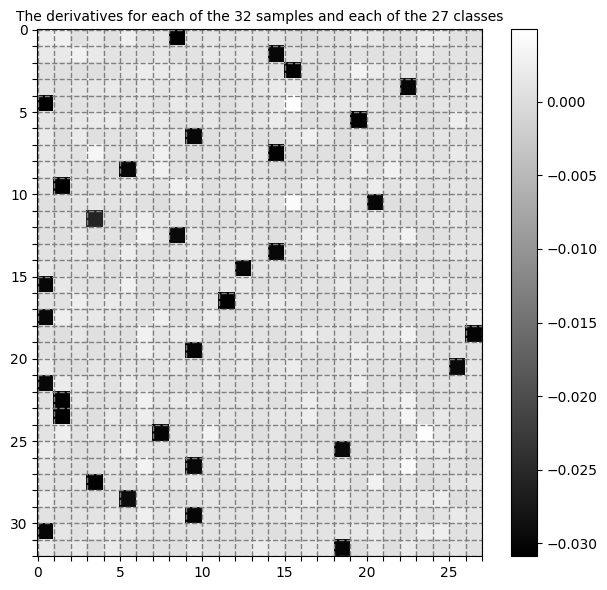

In [149]:
fig = plt.figure(figsize=(6, 6))
im = plt.imshow(dlogits.detach(), cmap='gray')
plt.title(label=f"The derivatives for each of the {d_logits.shape[0]} samples and each of the {d_logits.shape[1]} classes", fontsize=10)
plt.yticks(torch.arange(-0.475, d_logits.shape[0]+0.5),labels=[f'{x}' if x%5==0 else '' for x in range(d_logits.shape[0]+1)])
plt.xticks(torch.arange(-0.475, d_logits.shape[1]+0.5),labels=[f'{x}' if x%5==0 else '' for x in range(d_logits.shape[1]+1)])
plt.grid(True, linestyle="--", color="gray", linewidth=1)
fig.tight_layout()
plt.colorbar(use_gridspec=True)
plt.show()

# Here all the rows represent each of the samples in our batch where as the i'th columns are the derivatives for each of the probabilities for the i'th character in our vocabulary (i.e. probability predicted for class i)
# Notice all the black squares, which are the derivatives for the i'th characters where i==y, as their derivative was p[i]-1 instead of only p[i] 
# Remember from the earlier code cell that the sum of all of these derivatives are 0 => hence there are no extra "force" introduced by these derivatives into the network
# Our weights are updated as: w[i,j] = -lr * w[i,j].grad 
# Hence, when the gradients here for the characters at the (i==y)'th index gets pushed to the ground (by the -1 interpretation) and all other gradients will be slightly above 0, then the gradients here can be seen as a truncation, 
# or a force pushing the weights contributing to all the wrong predictions to do that less, while pulling the weights contributing to the correct prediction, to do more of that 
# Hence, these derivative of the logits can be seen like pulleys that are controlling the network and parameters into becoming what we want
# Hence, the amount of force is propertional to the amount of "incorrectness" in the predictions 
    # Due to the fact that the derivative of the exactely true prediction [0, 0, 1, 0] would be a row of all zeros, hence no push and pull (no parameter updates) would be applied 
# This is one of the reasons why the cross entropy is such a good loss function ... 

## Exercise 3

In [150]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

### now:
# This is a one-liner for the batch normalization forward pass:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [151]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

### Pre-information
# Remember that dL/dx^hat is a vector, as we have multiple x_hats.
    # Remember that the running mean and variance (mu and sigma) is scalar values, hence we have some broadcasting in the forward pass (means summation in backprop)
# 


dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 9.3132e-10


In [152]:
### Notice the different shapes here
# This indicates that we have had some kind of broadcasting along the columns, during the forward pass of the batch norm layer 
dhprebn.shape, bngain.shape, bnvar_inv.shape, dbnraw.shape, dbnraw.sum(0).shape

(torch.Size([32, 64]),
 torch.Size([1, 64]),
 torch.Size([1, 64]),
 torch.Size([32, 64]),
 torch.Size([64]))

## Exercise 4

In [ ]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

  # kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
      p.grad = None
    #loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n
    # 2nd layer backprop
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    # tanh
    dhpreact = (1.0 - h**2) * dh
    # batchnorm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    # 1st layer
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    # embedding
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

  #   if i >= 100: # TODO: delete early breaking when you're ready to train the full net
  #     break

In [ ]:
# useful for checking your gradients
# for p,g in zip(parameters, grads):
#   cmp(str(tuple(p.shape)), g, p)

In [ ]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)


In [ ]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

In [ ]:
# I achieved:
# train 2.0718822479248047
# val 2.1162495613098145

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # ------------
      # forward pass:
      # Embedding
      emb = C[torch.tensor([context])] # (1,block_size,d)      
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # ------------
      # Sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(i_to_s[i] for i in out))